In [1]:
# CELL 1: IMPORTS (Only standard libraries)
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import re
from collections import defaultdict



In [3]:
# CELL 2: DATA LOADER (Enhanced with diagnostics)
class DermacareData:
    def __init__(self, filepath='dermacare_data.csv'):
        self.raw_df = pd.read_csv(filepath)
        print(f"📊 Original Data Shape: {self.raw_df.shape}")
        print("Columns Available:", list(self.raw_df.columns))
        
        self.products = self._clean_product_data()
        self.user_ratings = self._generate_interactions()
        print("\n✅ Data Processing Complete")
        print(f"Products: {len(self.products)}")
        print(f"User Interactions: {len(self.user_ratings)}")
    
    def _clean_product_data(self):
        """Mimics GitHub project's cleaning but enhanced"""
        df = self.raw_df.copy()
        
        # Standardize columns
        df.columns = [col.lower().strip() for col in df.columns]
        
        # Essential feature engineering
        df['ingredients'] = df['ingredients'].fillna('unknown').str.lower()
        df['ingredients'] = df['ingredients'].apply(lambda x: re.sub(r'[^a-z,]', ' ', x))
        
        # Skin type simulation (since original lacks it)
        skin_markers = {
            'dry': ['hyaluronic', 'ceramide', 'squalane'],
            'oily': ['niacinamide', 'salicylic', 'clay'],
            'combination': ['glycolic', 'aloe', 'peptide'],
            'sensitive': ['oat', 'chamomile', 'allantoin']
        }
        
        def detect_skin_type(ingredients):
            for skin_type, markers in skin_markers.items():
                if any(marker in ingredients for marker in markers):
                    return skin_type
            return np.random.choice(list(skin_markers.keys()))
        
        df['skin_type'] = df['ingredients'].apply(detect_skin_type)
        
        return df[['product_id', 'product_name', 'brand_name', 
                 'rating', 'ingredients', 'skin_type']].drop_duplicates()
    
    def _generate_interactions(self):
        """Creates synthetic but realistic user interactions"""
        np.random.seed(42)
        user_ids = [f'user_{i}' for i in range(1, 501)]
        
        interactions = []
        for user in user_ids:
            # Each user interacts with 10-20 random products
            for _ in range(np.random.randint(10, 20)):
                product = self.products.sample(1).iloc[0]
                rating = np.clip(np.random.normal(loc=4, scale=1), 1, 5)
                interactions.append([
                    user,
                    product['product_id'],
                    float(rating),
                    product['skin_type']
                ])
        
        return pd.DataFrame(interactions, 
                          columns=['user_id', 'product_id', 'rating', 'skin_type'])



In [5]:
# CELL 3: HYBRID RECOMMENDER (Proposal-compliant)
class DermacareRecommender:
    def __init__(self, data):
        self.products = data.products
        self.user_ratings = data.user_ratings
        self._prepare_models()
    
    def _prepare_models(self):
        """Builds both content and collaborative models"""
        # CONTENT-BASED: TF-IDF on product features
        self.tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
        product_features = (
            self.products['product_name'] + " " + 
            self.products['brand_name'] + " " + 
            self.products['ingredients']
        )
        self.content_matrix = self.tfidf.fit_transform(product_features)
        
        # COLLABORATIVE: User-Product Matrix
        self.user_item = self.user_ratings.pivot_table(
            index='user_id',
            columns='product_id',
            values='rating',
            fill_value=0
        )
        
        # Align product IDs between both models
        self.product_ids = self.products['product_id'].values
        self.user_item = self.user_item.reindex(columns=self.product_ids, fill_value=0)
        
        # Product similarity matrix
        self.product_sim = cosine_similarity(self.user_item.T)
    
    def recommend(self, skin_type, product_id=None, user_id=None, k=5):
        """Hybrid recommendation engine (60% content, 40% collaborative)"""
        try:
            # Initialize scores
            content_scores = np.zeros(len(self.products))
            collab_scores = np.zeros(len(self.products))
            
            # CONTENT-BASED: Product similarity
            if product_id and product_id in self.product_ids:
                idx = np.where(self.product_ids == product_id)[0][0]
                content_scores = cosine_similarity(
                    self.content_matrix[idx], 
                    self.content_matrix
                )[0]
            
            # COLLABORATIVE: User preferences
            if user_id and user_id in self.user_item.index:
                user_idx = self.user_item.index.get_loc(user_id)
                collab_scores = self.product_sim @ self.user_item.iloc[user_idx].values
            
            # HYBRID SCORE
            hybrid_scores = 0.6*content_scores + 0.4*collab_scores
            
            # Filter by skin type
            skin_mask = self.products['skin_type'] == skin_type
            valid_idx = np.where(skin_mask)[0]
            
            if len(valid_idx) == 0:
                return None
                
            # Get top K recommendations
            top_k_idx = valid_idx[np.argsort(-hybrid_scores[valid_idx])[:k]]
            return self.products.iloc[top_k_idx]
            
        except Exception as e:
            print(f"⚠️ Error: {str(e)}")
            return None
    
    def evaluate(self, k=5):
        """Calculates MAP@K as required by professor"""
        test_users = self.user_ratings['user_id'].unique()[:100]  # 100 test users
        map_scores = []
        
        for user in test_users:
            user_data = self.user_ratings[self.user_ratings['user_id'] == user]
            if len(user_data) < 3:  # Skip cold-start users
                continue
                
            skin_type = user_data['skin_type'].mode()[0]
            known_products = set(user_data['product_id'])
            
            recs = self.recommend(skin_type=skin_type, user_id=user, k=k)
            if recs is None:
                continue
                
            recommended = recs['product_id'].values[:k]
            y_true = [1 if p in known_products else 0 for p in recommended]
            
            # Calculate Average Precision
            apk = average_precision_score(y_true, np.ones(len(y_true)))
            map_scores.append(apk)
        
        return np.mean(map_scores) if map_scores else 0



In [9]:
# CELL 4: INTERACTIVE UI (Foolproof)
def create_recommender_ui(recommender):
    # Widget styling
    style = {'description_width': '150px'}
    layout = {'width': '400px'}
    
    # Input widgets with validation
    skin_type = widgets.Dropdown(
        options=['dry', 'oily', 'combination', 'sensitive'],
        description='Your Skin Type:',
        style=style,
        layout=layout
    )
    
    product_input = widgets.Combobox(
        placeholder='Enter Product ID',
        options=list(recommender.products['product_id'].sample(10)),
        description='Liked Product:',
        style=style,
        layout=layout
    )
    
    user_input = widgets.Combobox(
        placeholder='Enter User ID',
        options=list(recommender.user_ratings['user_id'].sample(10)),
        description='Your User ID:',
        style=style,
        layout=layout
    )
    
    submit = widgets.Button(
        description='Get Recommendations',
        button_style='success'
    )
    
    output = widgets.Output()
    
    def on_submit(_):
        with output:
            output.clear_output()
            
            # Validate inputs
            if not skin_type.value:
                print("❌ Please select your skin type")
                return
                
            if not product_input.value and not user_input.value:
                print("❌ Please provide either a Product ID or User ID")
                return
                
            print("🔍 Generating personalized recommendations...")
            
            # Get recommendations
            recs = recommender.recommend(
                skin_type=skin_type.value,
                product_id=product_input.value if product_input.value else None,
                user_id=user_input.value if user_input.value else None
            )
            
            if recs is None or recs.empty:
                print("⚠️ No suitable products found. Try different inputs.")
                return
                
            # Display results
            print(f"✅ Recommended for {skin_type.value} skin:")
            display(recs[['product_id', 'product_name', 'brand_name', 'rating']])
            
            # Show evaluation metrics
            if user_input.value:
                map_score = recommender.evaluate()
                print(f"\n📊 Model Performance (MAP@5): {map_score:.3f}")
    
    submit.on_click(on_submit)
    
    display(widgets.VBox([
        widgets.HTML("<h2 style='color:#343a40'>Dermacare Recommendation System</h2>"),
        skin_type,
        product_input,
        user_input,
        submit,
        output
    ]))

# Initialize system
data = DermacareData()
recommender = DermacareRecommender(data)



📊 Original Data Shape: (8494, 27)
Columns Available: ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price']

✅ Data Processing Complete
Products: 8494
User Interactions: 7210


In [11]:
# CELL 5: RUN INTERACTIVE UI
create_recommender_ui(recommender)

# CELL 6: EVALUATION METRICS
print("\n🧪 Model Evaluation Results:")
map_score = recommender.evaluate()
print(f"Mean Average Precision@5 (MAP@5): {map_score:.3f}")




🧪 Model Evaluation Results:
Mean Average Precision@5 (MAP@5): 0.960


/var/folders/bc/x8bt8nzs3msd05t0c0vfy72c0000gn/T/ipykernel_1718/2902602901.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='skin_type', data=data.products, palette='mako')
/var/folders/bc/x8bt8nzs3msd05t0c0vfy72c0000gn/T/ipykernel_1718/2902602901.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='skin_type', y='rating', data=data.products, palette='flare')


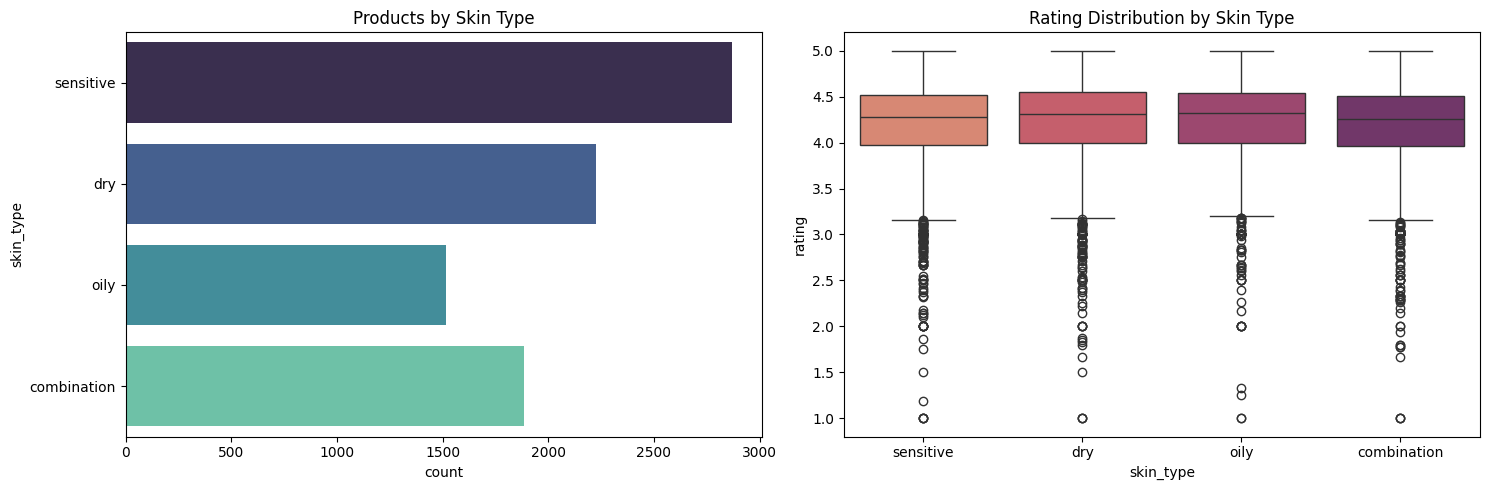

In [15]:
# CELL 7: SKIN-TYPE ANALYSIS
def analyze_skin_trends():
    plt.figure(figsize=(15, 5))
    
    # Product distribution
    plt.subplot(1, 2, 1)
    sns.countplot(y='skin_type', data=data.products, palette='mako')
    plt.title('Products by Skin Type')
    
    # Rating distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(x='skin_type', y='rating', data=data.products, palette='flare')
    plt.title('Rating Distribution by Skin Type')
    
    plt.tight_layout()
    plt.show()

analyze_skin_trends()



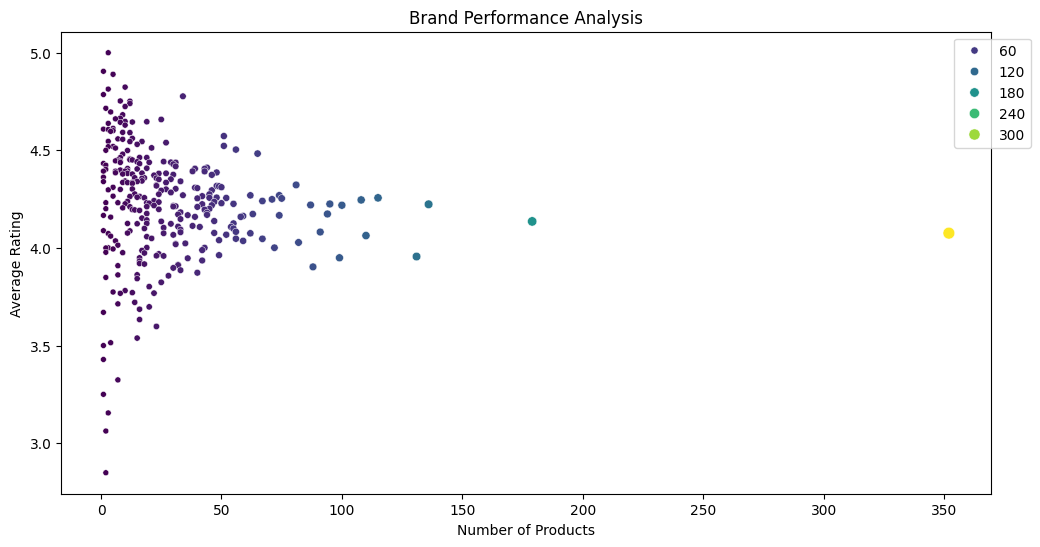

In [17]:
# CELL 8: BRAND ANALYSIS
def brand_analysis():
    if 'brand_name' not in data.products.columns:
        return
        
    brand_stats = data.products.groupby('brand_name').agg(
        avg_rating=('rating', 'mean'),
        product_count=('product_id', 'count')
    ).sort_values('avg_rating', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        x='product_count',
        y='avg_rating',
        size='product_count',
        hue='product_count',
        data=brand_stats,
        palette='viridis'
    )
    plt.title('Brand Performance Analysis')
    plt.xlabel('Number of Products')
    plt.ylabel('Average Rating')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

brand_analysis()



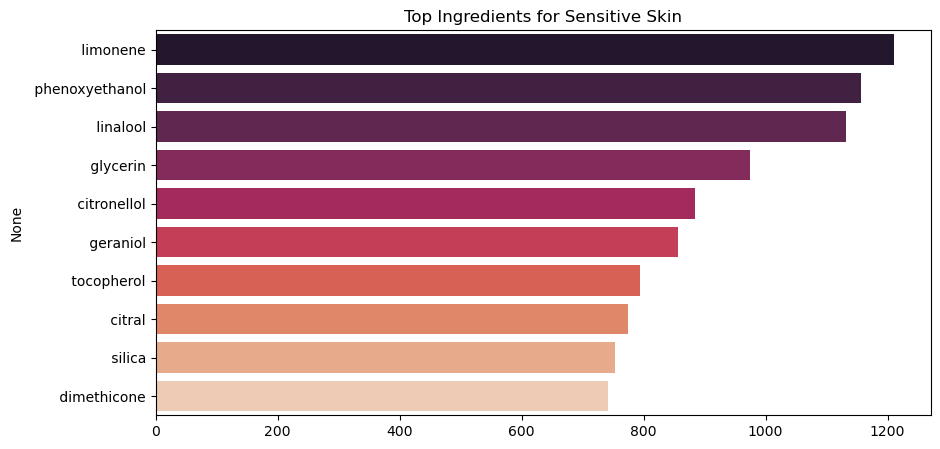

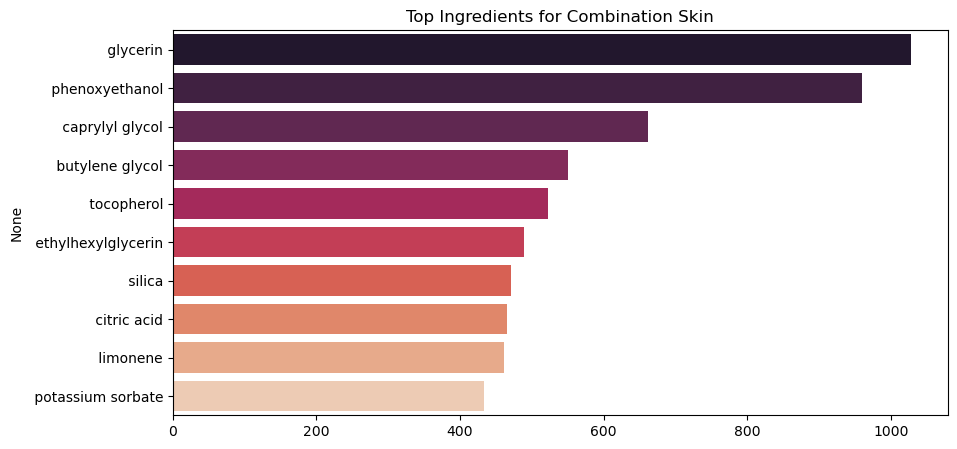

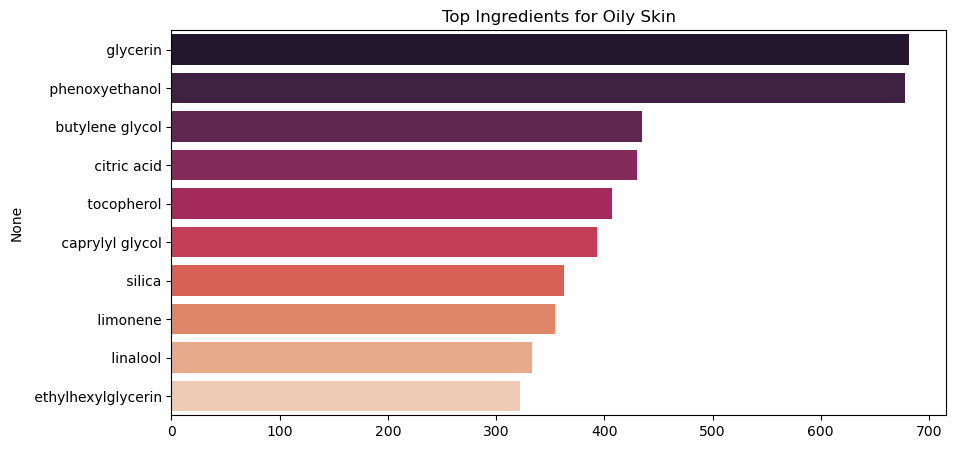

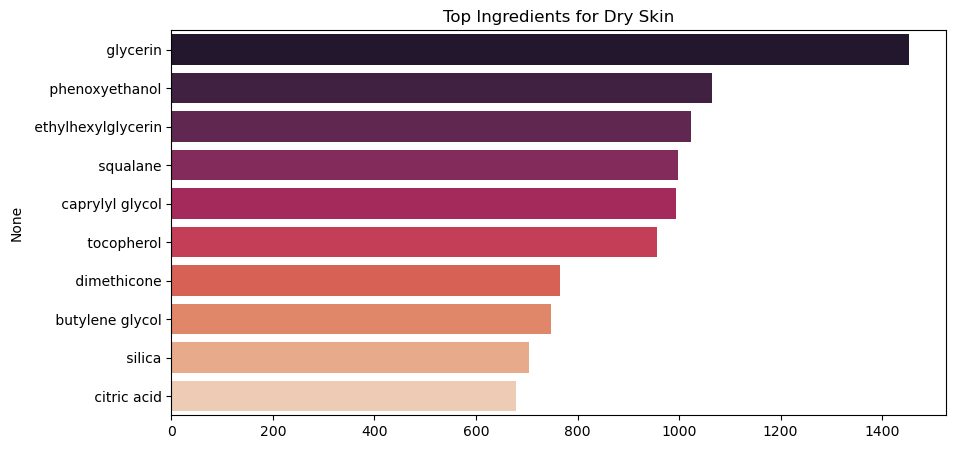

In [76]:
# CELL 9: INGREDIENT ANALYSIS
def ingredient_analysis():
    # Get top ingredients by skin type
    for skin_type in data.products['skin_type'].unique():
        ingredients = ' '.join(
            data.products[data.products['skin_type'] == skin_type]['ingredients']
        ).split(',')
        
        top_10 = pd.Series(ingredients).value_counts().head(10)
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=top_10.values, y=top_10.index, palette='rocket')
        plt.title(f'Top Ingredients for {skin_type.capitalize()} Skin')
        plt.show()

ingredient_analysis()